# Ramping through a spin-orbit resonance with SciBmad

BNL's Relativistic Heavy Ion Collider (RHIC) and its successor the Hadron Storage Ring (HSR) of the Electron-Ion Collider (EIC) are characterized by their high degree of polarization. The lack of a significant self-polarization mechanism for protons and ions means that these species have to be polarized at the source and accelerated without a significant loss of polarization. However, without special care, the electromagnetic fields used to accelerate the particles will destroy their polarization. This is often discussed in the context of the Alternating Gradient Synchrotron (AGS), as if particles cannot maintain their polarization through the AGS, there will be no polarization left to maintain once the particles reach RHIC/HSR.

The equation of motion for the rest-frame spin of relativistic particles is the Thomas-Bargmann-Michel-Telegdi (T-BMT) equation. As the length of the spin is constant (usually taken to be unity for simplicity), the T-BMT equation is a precession equation:
$$ \dot{\vec{S}}(t)=\vec{\Omega}(t)\times\vec{S}(t). $$
If there is only a magnetic field $\vec{B}$ in the lab frame, the precession vector takes the form
$$ \vec{\Omega}=-\frac{q}{m\gamma}\left[(1+G\gamma)\vec{B}_\perp+(1+G)\vec{B}_\parallel \right], $$
where $\perp$ and $\parallel$ indicate components perpendicular to and parallel to the particle's velocity. Comparing this equation to the Lorentz force, one sees that spins precess $G\gamma$ times faster than the orbit in a transverse field. Therefore, in a ring where a particle on the closed orbit has no vertical momentum in the bending magnets and sees no other fields, the closed-orbit spin tune $\nu_0$ is exactly equal to $G\gamma$. In rings without egregious misalignments or spin rotators, we often hope that this is approximately true.

In general, the precession vector $\vec{\Omega}$ is a quasiperiodic function of the position in the accelerator given by the azimuth $\theta$. As a function of phase space and the lattice, it must be periodic in the orbital angles and $\theta$. Hence, a Fourier decomposition in $\theta$ alone would contain frequencies of the form
$$\kappa=k_0+\vec{k}\cdot\vec{Q} \quad \mathrm{with}\,\left(k_0,\vec{k}\right)\in\mathbb{Z}^4, $$
where $\vec{Q}$ contains the orbital tunes. During the acceleration process, $\nu_0$, being approximately equal to $G\gamma$, usually increases, and we can reach the condition $\nu_0=\kappa$. We then speak of a "spin-orbit resonance", and the spin motion usually becomes wild in the vicinity of these resonances, as in the image below for $\kappa=0$. In the approximation of an isolated resonance, the effect of a linear crossing depends only on the resonance strength $\epsilon$ and the crossing speed $\alpha=(\nu_0-\kappa)/\theta$. However, the resonance strength $\epsilon$ depends on the orbital amplitude, and thus every particle's spin is changed differently. This can lead to a loss of polarization.

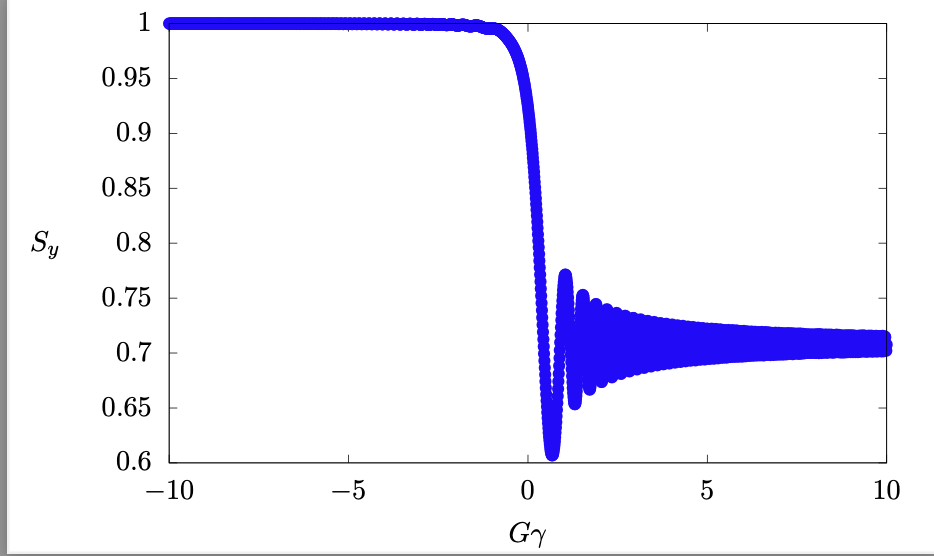

The desired polarization outside the interaction region is often vertical, because vertical spins are mostly unaffected by the vertical fields of the bending magnets. Resonances containing $Q_y$ then become extremely important because vertical motion in the quadrupoles leads to horizontal magnetic fields. It is therefore of interest to see what happens to a vertical spin when it passes through an isolated resonance at constant speed. Froissart and Stora (1963) found that, if the spin is vertical infinitely far before the resonance, then infinitely far after the resonance, the vertical component of the spin will become
$$ S_y=2\exp\left(-\frac{\pi\epsilon^2}{2\alpha}\right)-1. $$
As can be seen below, this formula is often quite accurate even when crossing from a finite distance, as long as the resonances are isolated. In the AGS, the isolated vertical resonances used to be very important. Even now, with the partial snakes, the isolated horizontal resonances are the most important and the Froissart-Stora theory still applies. Note, however, that in the general case, instead of the component of $\vec{S}$ along the vertical direction, we must consider the component along $\vec{n}_0$, the periodic spin direction on the closed orbit.
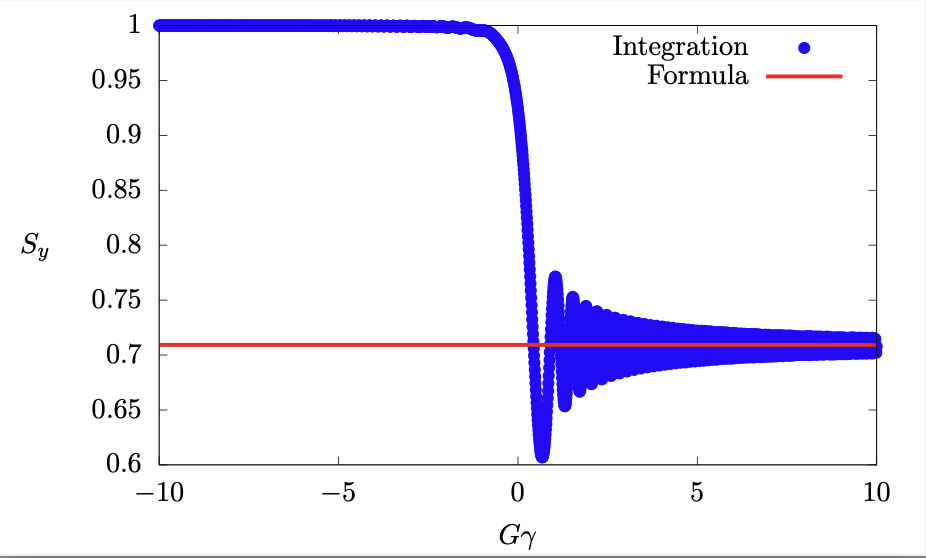

Now, onto the simulation. We will only need `SciBmad`, with `Plots` and `LaTeXStrings` included for plotting purposes:

In [15]:
from matplotlib import pyplot as plt
import numpy as np
from juliacall import Main as jl
jl.seval("using SciBmad")

We will use a simple FODO lattice based on the AGS with superperiod $P=60$:

In [2]:
ring = jl.include("../../lattices/ags.jl");

To know where to look for spin-orbit resonances, we have to know the tunes:

In [3]:
tw = jl.twiss(ring)
Qy = jl.scalar(tw.table.phi_2[-1])
Qy

8.984999999999708

Because the lattice has an exact superperiod of 60, we only expect first-order resonances at $\nu_0=60N \pm Q_y$ with $N\in\mathbb{Z}$. The ring is flat, so $\nu_0=G\gamma$ and we will track through the $\nu_0=60 + Q_y$ resonance. Let's start at $G\gamma=59 + Q_y$ and end at $G\gamma=61+Q_y$:

In [4]:
Gγ_start = 59 + Qy 
Gγ_end =   61 + Qy

We can convert to $E=\gamma mc^2$ using our physical constants package:

In [5]:
p = jl.Species("proton")
E_start = Gγ_start / jl.gyromagnetic_anomaly(p) * jl.massof(p)
E_end   = Gγ_end   / jl.gyromagnetic_anomaly(p) * jl.massof(p)

For applying the Froissart-Stora formula, the useful quantity is $\alpha = (\text{Change in $G\gamma$ per turn})/(2\pi)$. But for a tracking code (and in the control room), we use the rate of change in terms of time. So we need the (approximate) revolution time, using the fact that we are ultrarelativistic:

In [6]:
approx_rev_time = ring.line[-1].s_downstream/jl.C_LIGHT

Let's set it up so that the ramping takes place over 1,000 turns:

In [7]:
dE_dt = (E_end - E_start) / (1000 * approx_rev_time)

In `SciBmad`, ramping is extremely simple because almost everything (magnet strengths, cavity voltages, cavity frequencies, the reference energy, etc.) can be made a time-dependent function. This is done using the function `Time()`, which creates an object that will, when the particle reaches an element during tracking, evaluate to the current time. So, to ramp, we simply make the reference energy of the ring a time-dependent function.

Note that there are other ways to go through a resonance, e.g., to vary the tune by changing quadrupole strengths or to drive the resonance with an AC dipole. Using `Time()`, both of these are easily simulated in `SciBmad`. 

In [8]:
ring.E_ref = jl.seval(f"{E_start} + {dE_dt}*Time()")
# This is saying E_ref(t) = E_start + dE_dt*t, but it could also be more complicated like sin(Time()), etc.

Let's start with a vertical offset $(y=0.25\,\text{mm},\,p_y=0)$ and vertical spin. We will initialize a bunch, and then because this lattice doesn't have RF cavities in it, we will use the simple ramping model which ramps the particle energy uniformly. 

To do this, we will write a tracking loop, and specify the `track!` keyword argument `ramp_particle_energy_without_rf`. Each turn, we'll store the vertical spin component in an array. Because SciBmad tracks quaternions, we can use the `rotate_spins` function to see how an initial spin evolves given the quaternion.

In [9]:
# Initialize bunch
v0 = np.matrix([0.0, 0.0, 2.5e-4, 0.0, 0.0, 0.0]) # Initial phase space coordinate
q0 = np.matrix([1.0, 0.0, 0.0, 0.0]) # Identity quaternion (Because SciBmad tracks quaternions)
b0 = jl.Bunch(jl.Array(v0), jl.Array(q0)) # Note: must be converted to Julia arrays for performance

s_initial = np.matrix([0.0, 1.0, 0.0]) # Initial spin will be vertical
s_y = np.zeros(1001)  # Vector to store vertical spin component at each turn
s_y[0] = 1 # Initial spin will be vertical

# Also store Gγ for plotting:
Gγ = np.zeros(1001)
Gγ[0] =  jl.gyromagnetic_anomaly(p) * ring.E_ref(0) / jl.massof(p)

for i in range(1, 1001):
    
    # Track one turn:
    jl.track_b(b0, ring, ramp_particle_energy_without_rf=True)

    # Store the result
    s_final = jl.rotate_spins(b0.coords.q, s_initial)
    s_y[i] = s_final[0, 1] # [s_x, s_y, s_z] -> second element is vertical

    # current reference time is in Bunch.t_ref
    t_ref = b0.t_ref
    Gγ[i] = jl.gyromagnetic_anomaly(p) * ring.E_ref(t_ref) / jl.massof(p)

Setting bunch.species = Species(proton, charge=1.0e, mass=9.382720894300001e8 eV/c², spin=0.5ħ) (reference species from the Beamline)
Setting bunch.p_over_q_ref = 118.63882003823007 (reference p_over_q_ref from the Beamline at t_ref = 0.0)


Let's plot the vertical spin component now, as a function of $G\gamma_0$

Text(0, 0.5, 'S_y')

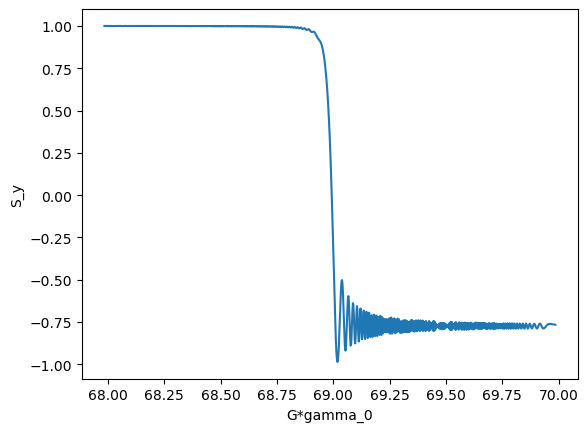

In [10]:
plt.plot(Gγ, s_y)
plt.xlabel("G*gamma_0")
plt.ylabel("S_y")

This indeed looks like a Froissart-Stora crossing. We can compute the resonance strength by looking at $S_y$ at the end and inverting the Froissart-Stora formula:

In [11]:
epsilon = np.sqrt(2*(2/1000)/np.pi*np.log(2/(1+s_y[-1])))
epsilon

np.float64(0.05226007726137334)

Now, we can write a function which (in the isolated-resonance approximation) gives us the final $S_y$ for any ramping rate $\alpha$:

In [12]:
f = lambda alpha : 2*np.exp(-np.pi*epsilon**2/(2*alpha)) - 1

Let's try some other ramping rates and see how the final $S_y$ varies with $\alpha$ (or equivalently the number of turns over which the ramping takes place):

In [13]:
turns = [1, 2, 5, 7, 10, 20, 50, 70, 100, 200, 500, 700, 1000, 2000, 5000, 7000]
final_s_y = np.zeros(len(turns))

for (i,N) in enumerate(turns):
    ring.E_ref = jl.seval(f"{E_start} + {1000/N*dE_dt}*Time()")

    # Initialize bunch
    v0 = np.matrix([0.0, 0.0, 2.5e-4, 0.0, 0.0, 0.0]) # Initial phase space coordinate
    q0 = np.matrix([1.0, 0.0, 0.0, 0.0]) # Identity quaternion (Because SciBmad tracks quaternions)
    b0 = jl.Bunch(jl.Array(v0), jl.Array(q0), species=ring.species_ref, p_over_q_ref=ring.p_over_q_ref(0))

    # Track
    for _ in range(0,N):
        jl.track_b(b0, ring, ramp_particle_energy_without_rf=True)

    # Store result
    final_s = jl.rotate_spins(b0.coords.q, s_initial)
    final_s_y[i] = final_s[0, 1]

Now we can plot these results against the Froissart-Stora function we wrote:

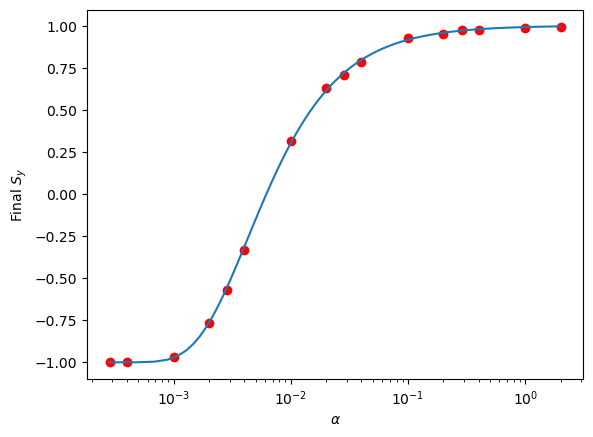

In [14]:
plt.plot(np.linspace(2/turns[0], 2/turns[-1], num=10000), [f(x) for x in np.linspace(2/turns[0], 2/turns[-1], num=10000)])
plt.xscale("log")
plt.xlabel("$\\alpha$")
plt.ylabel("Final $S_y$")
plt.scatter(2 / np.array(turns), final_s_y, color="red")

The agreement is excellent, but of course not perfect (why?). This is one of many cute methods for computing resonance strengths in the isolated-resonance approximation (see J. P. Devlin and G. H. Hoffstaetter in Proc. IPAC '24).